In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('C://Users//Igor//Desktop//data_analyst//5 project//hypothesis.csv')
orders = pd.read_csv('C://Users//Igor//Desktop//data_analyst//5 project//orders.csv')
visitors = pd.read_csv('C://Users//Igor//Desktop//data_analyst//5 project//visitors.csv')

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


## 1. Сделаем приоритезацию гипотиз по ICE

In [6]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

In [7]:
hypothesis.sort_values('ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


In [8]:
hypothesis.sort_values('RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


### Вывод: при использовании RICE на первое место вышла гипотиза у которой охват 10, в то время как при использовании ICE на первом месте была гипотиза с охватом 1, что явно является неправильным приоритетом.

## 2. Анализ А/В теста

### 2.1 Анализ кумулятивной выручки по группам 

In [9]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

In [10]:
datesGroups = orders[['date','group']].drop_duplicates()

In [11]:
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [12]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
    {'date':'max', 'group':'max','transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}
    ),axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
    {'date':'max', 'group':'max','visitors':'sum'}
    ),axis=1).sort_values(by=['date','group'])

In [13]:
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [14]:
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [15]:
cumulativeData = visitorsAggregated.merge(ordersAggregated,left_on=['date','group'],right_on=['date','group'])
cumulativeData.columns= ['date','group','visitors','transactions','buyers','revenue']
cumulativeA=cumulativeData[cumulativeData['group']=='A']
cumulativeB=cumulativeData[cumulativeData['group']=='B']
cumulativeB.head()


,date,group,visitors,transactions,buyers,revenue
1,2019-08-01,B,713,21,20,101217
3,2019-08-02,B,1294,45,43,266748
5,2019-08-03,B,1803,61,59,380996
7,2019-08-04,B,2573,78,75,489567
9,2019-08-05,B,3280,101,98,581995


График кумулятивной выручки по группам


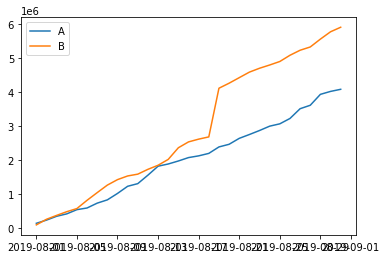

In [16]:
plt.plot(cumulativeA['date'],cumulativeA['revenue'],label='A')
plt.plot(cumulativeB['date'],cumulativeB['revenue'],label='B')

plt.legend()
print('График кумулятивной выручки по группам')

### Вывод: выручка группы В стала значительно выше примерно в середине эксперимента, чем выручка группы А

### 2.2 Анализ кумулятивного среднего чека по группам

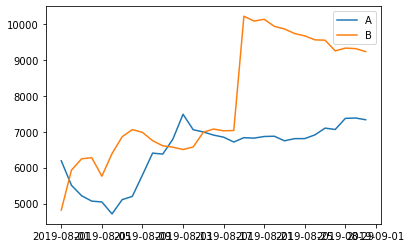

In [17]:
plt.plot(cumulativeA['date'], cumulativeA['revenue']/cumulativeA['transactions'], label = 'A')
plt.plot(cumulativeB['date'], cumulativeB['revenue']/cumulativeB['transactions'], label = 'B')
plt.legend()

### Вывод: видим выброс по середине графика у группы B, возможно если бы не эта аномалия то графики были бы равны.

### 2.3 Анализ относительного изменения кумулятивного среднего чека

In [18]:
mergedCumulativeRevenue = cumulativeA.merge(cumulativeB, left_on=['date'],right_on=['date'],suffixes=['A','B'])
mergedCumulativeRevenue.head()

,date,groupA,visitorsA,transactionsA,buyersA,revenueA,groupB,visitorsB,transactionsB,buyersB,revenueB
0,2019-08-01,A,719,24,20,148579,B,713,21,20,101217
1,2019-08-02,A,1338,44,38,242401,B,1294,45,43,266748
2,2019-08-03,A,1845,68,62,354874,B,1803,61,59,380996
3,2019-08-04,A,2562,84,77,425699,B,2573,78,75,489567
4,2019-08-05,A,3318,109,100,549917,B,3280,101,98,581995


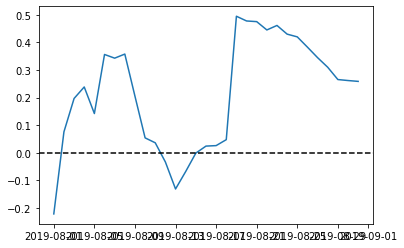

In [19]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['transactionsB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['transactionsA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 

### Вывод: график сильно скачит, значит в данных точно где то есть выбросы.

### 2.5 Анализ относительного изменения кумулятивной конверсии группы В к группе А

In [20]:
cumulativeData['conversion'] = cumulativeData['transactions'] / cumulativeData['visitors']

In [21]:
cumulativeA = cumulativeData[cumulativeData['group']=='A']
cumulativeB = cumulativeData[cumulativeData['group']=='B']
cumulativeA.head()

,date,group,visitors,transactions,buyers,revenue,conversion
0,2019-08-01,A,719,24,20,148579,0.033380
2,2019-08-02,A,1338,44,38,242401,0.032885
4,2019-08-03,A,1845,68,62,354874,0.036856
6,2019-08-04,A,2562,84,77,425699,0.032787
8,2019-08-05,A,3318,109,100,549917,0.032851


(18109.0, 18139.0, 0.02, 0.05)

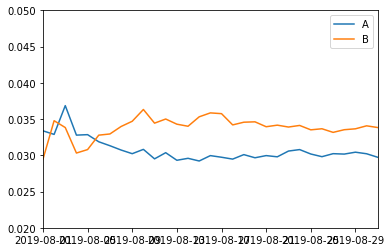

In [22]:
date1 = dt.datetime(2019,8,1)
date2 = dt.datetime(2019,8,31)

plt.plot(cumulativeA['date'],cumulativeA['conversion'], label='A')
plt.plot(cumulativeB['date'],cumulativeB['conversion'], label='B')
plt.legend()
plt.axis([date1, date2, 0.02, 0.05]) 

### Вывод: в начале графики колебались, но достаточно быстро стабилизировались и конверсия группы В зафиксировалась выше группы А.

### 2.6 Анализ точечного графика количества заказов по пользователям

,visitorId,transactionId,revenue
0,5114589,1,570
1,6958315,1,1490
2,8300375,2,12300
3,11685486,1,6201
4,39475350,1,3990


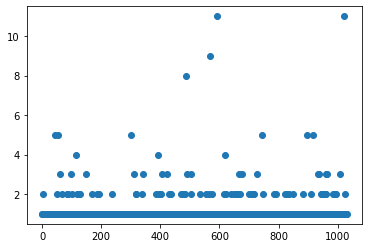

In [23]:
count_transactions = orders.groupby('visitorId').agg({'transactionId':'count','revenue':'sum'}).reset_index()
x_values = pd.Series(range(0,len(count_transactions['visitorId'])))
plt.scatter(x_values, count_transactions['transactionId'])
count_transactions.head()

### Вывод: из точечного графика видно, что есть выбросы в виде количества заказов больше 5 штук. 

### 2.7 Посчитаем 95 и 99 процентиль количества заказов на пользователя, выберем границу для опеределения аномальных значений.

In [24]:
print(np.percentile(count_transactions['visitorId'],[95,99]))

[4.03708104e+09 4.24195110e+09]


### Вывод: 95 и 99 прецентели почти не отличаются, поэтому возьмем за границу 95 (4 заказа)

### 2.8 Построим точечный график стоимости заказов 

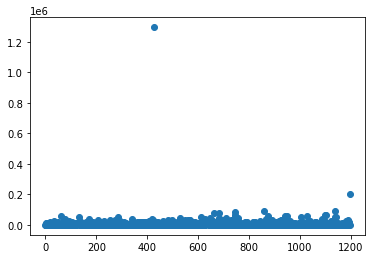

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

### Вывод: видим всего 2 больших выброса 

### 2.9 Посчитаем 95 и 99 прецентили стоимости заказов

In [26]:
print(np.percentile(orders['revenue'],[95,99]))

[28000.  58233.2]


### Вывод: разница в стоимости заказа 95 и 99 прецентиля более чем в 2 раза. Оставим границу на 95 процентеле (28000). 

### 2.10 Анализ статистической значимости различий в конверсии между группами по «сырым» данным

In [27]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - orders.groupby('group').agg({'visitorId':'nunique'})['visitorId'][0]
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - orders.groupby('group').agg({'visitorId':'nunique'})['visitorId'][1]
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.149


### Вывод: относительный прирост группы B составил 15%, p-value = 0.011, по неочищенным данным разница в конверсии между группами A и B статистически значима.

### 2.11 Анализ статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

In [28]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1))

p-value = 0.729
0.259


### Вывод: средний чек группы B больше группы А на 26%, p-value = 0.72, по неочищенным данным разница в среднем чеке между группами A и B статистически не значима.

### 2.12 Анализ статистической значимости различий в конверсии между группами по «очищенным» данным

In [29]:
sampleAclear = sampleA[sampleA<5]
sampleBclear = sampleB[sampleB<5]

In [30]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAclear, sampleBclear)[1]))
print("{0:.3f}".format(sampleBclear.mean() / sampleAclear.mean() - 1))

0.010
0.165


### Вывод: относительный прирост группы B составил 16,5%, p-value = 0.01, по очищенным данным разница в конверсии между группами A и B статистически значима.

### 2.13 Анализ статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [31]:
orders 

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [32]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', orders['revenue'] <= 28000)]['revenue'], orders[np.logical_and(orders['group']=='B', orders['revenue'] <= 28000)]['revenue'])[1]))
print("{0:.3f}".format(orders[np.logical_and(orders['group']=='A', orders['revenue'] <= 28000)]['revenue'].mean() / orders[np.logical_and(orders['group']=='B', orders['revenue'] <= 28000)]['revenue'].mean() - 1))

p-value = 0.852
0.016


### Вывод: теперь средний чек группы А стал больше на 1.6%, но p-value равен 0.852, что означает что разница в средних чеках статистически не значима.

### 2.14 Вывод.
По результатам анализа очищенных и неочищенных данных мы видим, что конверсия в обоих случаях больше в группе В и разница статстически значима, вероятность ошибится около 1%, график стабилизировался. Анализ среднего чека не показал явного победителя, при это график еще скачет, но при очищенных данных разница в средних чеках минимальна. Мы выявили явного победителя - группу В, тест можно останавливать.